In [1]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR, POST_EST_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
from config import mod7_params, fred_dict, recession_dict

In [3]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data

import numpy as np
import xarray as xr
import pandas as pd

import os
import time

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [4]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df = df.rename(columns={'pi_s': 'pi_obj'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [5]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)

Model Building Complete.
Found:
	25 equations
	25 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	5 stochastic shocks
		 0 / 5 has a defined prior. 
	18 parameters
		 0 / 18 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [6]:
# assign parameters
mod.free_param_dict.update(mod7_params)

In [7]:
mod.steady_state()
mod.solve_model()
mod.check_bk_condition();

Steady state found! Sum of squared residuals is 2.3034213894186284e-23
Solution found, sum of squared residuals:  5.233950627320991e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


## Kalman Filter Estimation

In [37]:
observed = ["Y", "pi_obj"]

filter_vars = list(mod.T.columns)
observed_ind = [filter_vars.index(item) for item in observed]
for i in observed:
    assert (i in filter_vars) == True, f"{i} not in filter_vars"

    
xdim = len(filter_vars)
zdim = len(observed)
print(f'xdim: {xdim} \nzdim: {zdim}')

xdim: 25 
zdim: 2


In [38]:
from filterpy.kalman import KalmanFilter
kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)

kfilter.F = mod.T.loc[filter_vars, filter_vars].values

kfilter.R = np.eye(zdim) * 0.01

for i, ind in enumerate(observed_ind):
    kfilter.H[i, ind] = 1

In [39]:
zs = train[observed].values

In [40]:
# kfilter.predict()
# kfilter.update(zs[0])
# kfilter.log_likelihood_of(zs[0])

In [41]:
mu, cov, _, _ = kfilter.batch_filter(zs)

In [42]:
mu_df = pd.DataFrame(mu.reshape(len(mu), -1), columns=filter_vars)
mask_f = mu_df[[item for item in train.columns if item in mu_df.columns]].copy()
mask_t = train[list(mask_f.columns)].reset_index(drop=True).copy()

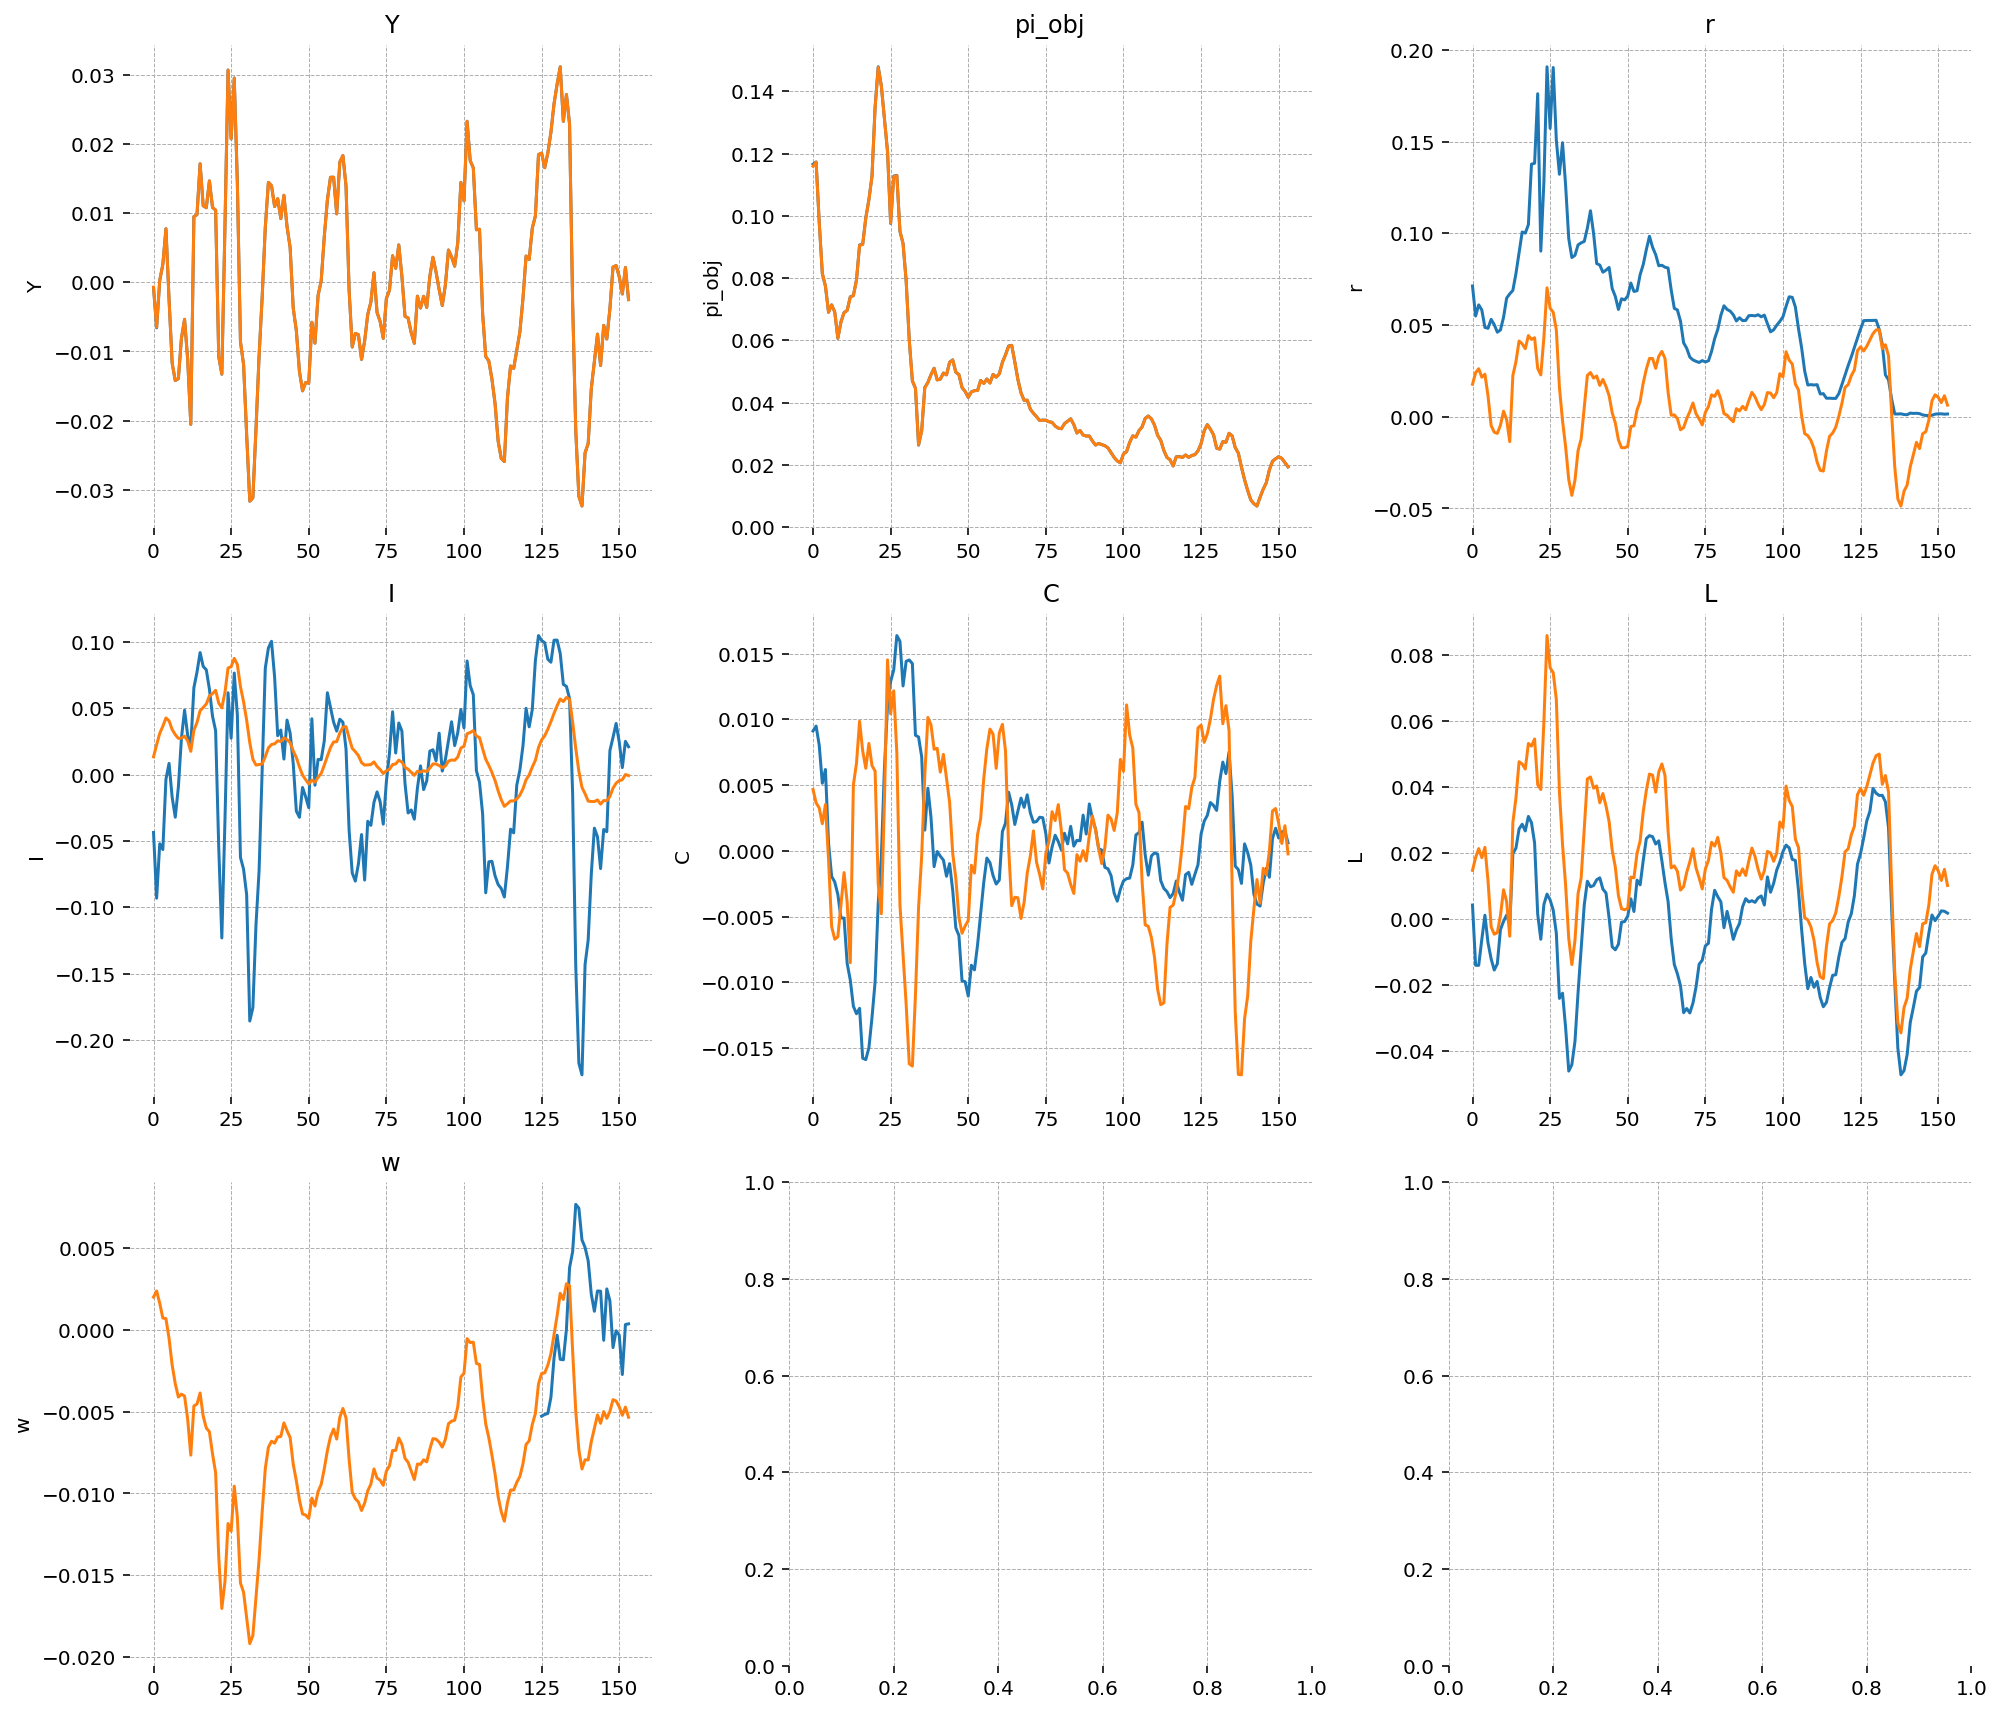

In [43]:
plot_dfs([mask_t, mask_f], sns.lineplot)

''

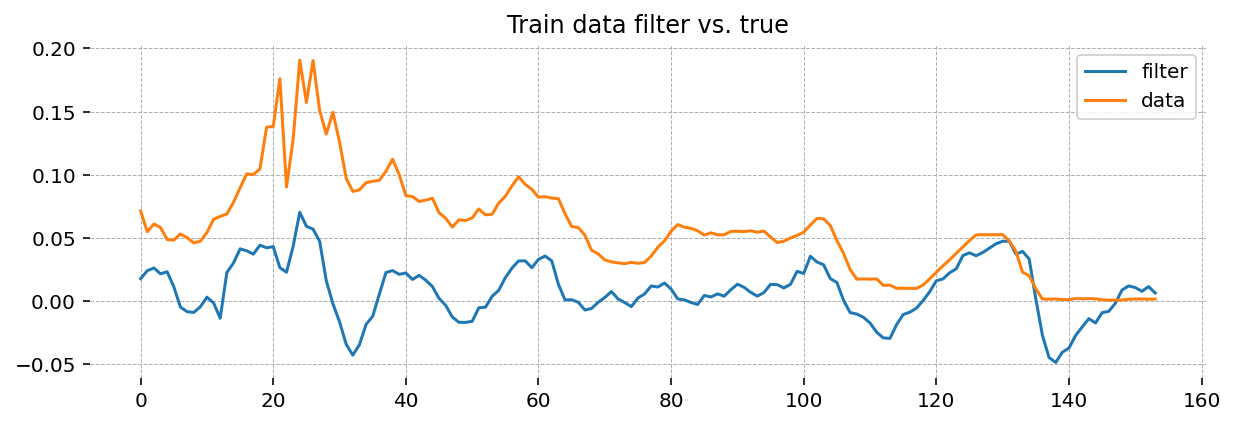

In [44]:
var = "r"
plt.plot(mu[:, filter_vars.index(var)].reshape(-1))
try:
    plt.plot(train[var].values)
except KeyError:
        _ = False
plt.title("Train data filter vs. true")
plt.legend(['filter', 'data'])
;

## drawing from priors

In [45]:
from scipy.stats import gamma, norm, beta, uniform
import scipy

In [46]:
def solve_updated_mod(mod, verbose: bool=True):
    
    # solve for steady state
    mod.steady_state(verbose=verbose)
    is_solved = mod.steady_state_solved
    if not is_solved:
        return False, mod
    
    # solve model, capture np.LinAlgEr
    try:
        mod.solve_model(verbose=verbose)
    except np.linalg.LinAlgError:
        return False, mod

    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool', verbose=verbose)
            
    return is_solved & is_bk, mod

In [47]:
from filterpy.kalman import KalmanFilter
def get_kalman_log_likelihood(observed_vars: list, all_vars: list,
                              measurements: np.array, T: np.array,
                              R_diag: list, ret_all: bool = False):
    
    # outputs
    log_likelihood = []
    mu, cov = None, None
    
    if ret_all:
        mu, cov = [], []
    
    observed_ind = [all_vars.index(item) for item in observed_vars]
    
    # sanity
    # add measurement == observed sanity
    for i in observed_vars:
        assert (i in all_vars) == True, f"{i} not in filter_vars"
        
    
    xdim = len(all_vars)
    zdim = len(observed_vars)
        
    # initialising the Kalman Filter
    kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
    kfilter.F = T
    kfilter.R = np.diag(R_diag)
    for i, ind in enumerate(observed_ind):
        kfilter.H[i, ind] = 1
        
    # predict, update, loglike
    for i in measurements:
        kfilter.predict()
        kfilter.update(i)
        
        log_likelihood.append(kfilter.log_likelihood)
        if ret_all:
            mu.append(kfilter.x_post)
            cov.append(kfilter.P_post)
            
    return log_likelihood, mu, cov

In [48]:
def get_arr_pdf_from_dist(dict_vals, dict_dists):
    # Get pdf from distribution for val
    return np.array([dict_dists[item].pdf(dict_vals[item]) for item in dict_vals.keys()])

In [49]:
def printProgBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    perc = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {perc}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
    pass

In [50]:
test, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                           list(mod.T.columns),
                                           train[["Y", "pi_obj"]].values,
                                           T=mod.T.values,
                                           R_diag=[.01, .01],
                                           ret_all=False)

In [51]:
prior_dist = {
    # 'alpha': beta(1.4, 10),
    'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    'sigma_L': gamma(a=1.9, loc=0, scale=2.63157894736842),
    'eta_p': beta(2.4, 1.2),
    'eta_w': beta(2.4, 1.2),
    'phi_H': beta(1.2, 1.2)
            }

In [ ]:
start = time.time()

mod_out = {}
n_param_dim_out = []
n_dim_out = []

# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
counter = 0.0
n_runs = 1000

posterior = {item: [mod7_params[item]] for item in prior_dist.keys()}

# reset params
mod.free_param_dict.update(mod7_params)

for i in range(0, n_runs):
    printProgBar(i, n_runs-1, prefix='Progress')
    
    # old log_likelihood
    old_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    old_loglike = sum(old_loglike)

    # draw params from prior & update
    old_prior = {item: vals[-1] for item, vals in posterior.items()}
    new_prior = {k: v for k, v in zip(prior_dist.keys(), [item.rvs() for item in prior_dist.values()])}
    # mod.free_param_dict.update(prior)
    
    # solve model
    is_solved, mod = solve_updated_mod(mod, verbose=False)
    if not is_solved: continue
    
    # new loglikelihood
    new_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    new_loglike = sum(new_loglike)
    
    # MH ratio
    ratio = ((new_loglike * get_arr_pdf_from_dist(new_prior, prior_dist)) / (old_loglike * get_arr_pdf_from_dist(old_prior, prior_dist))).mean()
    ω = min([ratio, 1])
    
    random = np.random.uniform(0, 1)
    
    # merge draws prior into posterior 
    if random <= ω:
        is_accepted = True
        counter += 1.
        for key in new_prior.keys():
            posterior[key].append(new_prior[key])
            
    # leave posterior unaltered and restart
    else:
        is_accepted = False
        counter += 0.
    
    
    
    # save output 
    n_param_dim_out.append(
        [
            [posterior[item][-1] for item in posterior.keys()],
            list(new_prior.values()),
            list(get_arr_pdf_from_dist(new_prior, prior_dist))
        ]
    )
    
    n_dim_out.append(
        [
            new_loglike
        ]
    )
    
    # mod_out[i] = dict(
    #     zip(
    #         [
    #             'is_solved',
    #             'is_accpeted_MH',
    #             'params',
    #             'T',
    #             'R',
    #             'loglike'
    #         ],
    #         [
    #             is_solved,
    #             is_accepted,
    #             mod.free_param_dict,
    #             mod.T,
    #             mod.R,
    #             new_loglike
    #         ]
    #     )
    # )
        

print(f"\nAcceptance rate = {round(counter/n_runs, 3)}")
print(f'\nExecution time = {round(time.time() - start, 3)} sec')
n_param_dim_out = np.array(n_param_dim_out)
n_dim_out = np.array(n_dim_out)

In [ ]:
# construct xarray

xarr = xr.Dataset(
    {
        'posterior': (['draw', 'parameter'], n_param_dim_out[:, 0]),
        'new_prior': (['draw', 'parameter'], n_param_dim_out[:, 1]),
        'new_prior_pdf': (['draw', 'parameter'], n_param_dim_out[:, 2]),
        'log_like': (['draw'], n_dim_out.reshape(-1))
    },
    coords={
        'draw': (['draw'], list(range(0, n_runs))),
        'parameter': (['parameter'], list(prior_dist.keys()))
    },
)
# xarr

In [ ]:
param = 'eta_w'
bins = int(n_runs/10)
plt.hist(xarr.sel(parameter=param).posterior[int(n_runs/2):], bins=bins, density=True);
plt.hist([prior_dist[param].rvs() for item in np.linspace(0, 10, int(n_runs/2))], bins=bins, density=True);
plt.legend(['posterior', 'prior'])

save results 

In [44]:
import pickle
import datetime

suffix = f'{datetime.datetime.now().date()}_{datetime.datetime.now().hour}_{datetime.datetime.now().minute}'

xarr.to_netcdf(os.path.join(DATA_DIR, f"posterior_sym_{suffix}.nc"))

f = open(os.path.join(DATA_DIR, f"mod_sym_{suffix}.pkl"),"wb")
pickle.dump(mod_out,f)
f.close()